In [10]:
### 03. 데이터 준비하기.ipynb의 내용 (scaled_data 사용하기 위한 코드)
import pandas as pd
import seaborn as sns

# 판다스 출력 결과를 소수점 둘째 자리 까지로 제한
pd.options.display.float_format = '{:,.2f}'.format

sales_df = pd.read_csv('data/sales_data.csv', index_col=['customer_id'])
sales_df
# =====
# 이상치 제거 함수
def get_outlier_mask(df, weight=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 - Q1
    IQR_weight = IQR * weight

    range_min = Q1 - IQR_weight  # 정상범위의 최소값
    range_max = Q3 + IQR_weight  # 정상범위의 최대값

    outlier_per_column = (df < range_min) | (df > range_max)  # 최소값보다 작거나, 최대값보다 크면 이상치로 간주. 
                                                              # -> 불린값을 Pandas Series로 반환..할 듯
    
    is_outlier = outlier_per_column.any(axis=1)  # 각 행에 대하여 True 혹은 False 값을 가진 Pandas Series가 반환됨. (True이면 이상치.)

    return is_outlier
# =====
outlier_idx_cust_df = get_outlier_mask(sales_df, weight=1.5)  # True/False 값을 가진 Pandas Series가 반환됨.

# 아웃라이어 제거한 데이터 프레임만 추가
sales_df = sales_df[~outlier_idx_cust_df]
# =====
df_mean = sales_df.mean()  # 각 컬럼의 평균값
df_std = sales_df.std()  # 각 컬럼의 표준편차

scaled_df = (sales_df - df_mean) / df_std  # 컬럼별 표준화 진행 ~> 이게 왜 표준화가 되지?

# 컬럼명 설정.
scaled_df.columns = ['total_buy_cnt', 'total_price']

# 인덱스 설정
scaled_df.index = sales_df.index

scaled_df

,total_buy_cnt,total_price
customer_id,,
12471,-0.99,-0.66
12557,-0.40,-0.71
12600,-0.88,0.33
12686,1.74,0.57
12748,-0.74,-0.60
...,...,...
17949,-1.33,-0.45
17951,-0.03,0.50
18085,0.93,1.59


k-means 모델로 클러스터링한 결과를 해석해 보겠습니다. 먼저, 이전 레슨에서 정한 k값을 사용해서 클러스터링을 다시 해 볼게요.

In [11]:
model = KMeans(n_clusters=5, random_state=123)
model.fit(scaled_df)

c:\Users\emma1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5, random_state=123)

`predict()` 함수를 쓰면 학습된 모델에 기반해 특정 고객이 어느 클러스터로 구분되는지 확인할 수 있었죠?  
해당 결과를 원본 데이터인 `sales_df`에 `label` 필드로 추가합니다.

In [12]:
sales_df['label'] = model.predict(scaled_df)

스케일링 된 데이터로 분석하면 고객의 특성을 정확하게 반영하기 어렵습니다.  
그래서, `scaled_df`로는 클러스터링까지만 진행하고, 실제 분석은 데이터의 특성이 그대로 남아있는 `sales_df`를 사용할게요.

## 클러스터링 결과 해석
먼저, 클러스터가 나눠진 결과를 시각화해 보겠습니다.

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

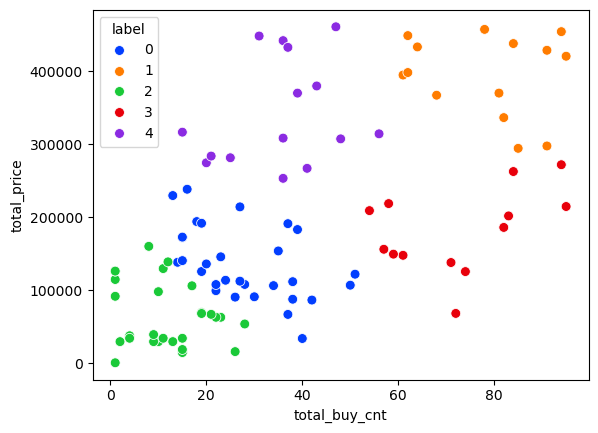

In [17]:
sns.scatterplot(x=sales_df['total_buy_cnt'], y=sales_df['total_price'], hue=sales_df['label'], s=50, palette='bright')

총 구매 수량, 총 구매 금액이 증가하는 정도에 따라 5개의 클러스터로 나눠지네요.

다음으로, 각 클러스터에 속해있는 고객 수를 확인해 보겠습니다.

In [18]:
pd.DataFrame(sales_df['label'].value_counts())  # sales_df의 'label' 컬럼에서 각 값의 개수를 세어 데이터프레임 형식으로 출력.

,count
label,
2,30
0,30
4,15
1,14
3,13


클러스터 2의 고객이 30명으로 가장 많고, 클러스터 3의 고객이 13명으로 가장 적네요.

다음으로 groupby()를 통해 각 클러스터별 구매 행동 특징을 살펴볼 건데요.  
`mean()` 함수로 클러스터별 총 구매 금액과 총 구매 수량의 평균값을 확인해 보겠습니다.

In [22]:
groupby_df = sales_df.groupby('label').mean()

그리고, 총 구매 금액(`total price`)을 총 구매 수량(`total_buy_cnt`)으로 나눈 평균 개당 가격(`price_mean`) 컬럼도 추가해 볼게요.

In [23]:
groupby_df['price_mean'] = groupby_df['total_price'] / groupby_df['total_buy_cnt']

In [25]:
groupby_df

,total_buy_cnt,total_price,price_mean
label,,,
0,27.80,"135,466.00","4,872.88"
1,78.43,"395,395.00","5,041.47"
2,11.77,"61,984.67","5,267.82"
3,72.62,"180,492.31","2,485.59"
4,35.40,"342,400.00","9,672.32"


클러스터 1의 고객들은 총 구매 수량과 금액이 가장 많고, 개당 구매 가격도 많은 편입니다.  
해당 클러스터의 고객들은 가격이 높은 물품을 많이 구매한다는 특징이 있는 것으로 해석할 수 있습니다.

클러스터 4의 고객들은 총 구매 금액과 개당 가격이 높지만, 총 구매 수량은 적습니다.  
수량은 많지 않지만 비싼 물품을 사는 고객이라는 것을 알 수 있습니다. 

결과를 바탕으로 프로모션을 진행하면 고객 클러스터별 특징에 따라 맞춤 전략을 짤 수 있습니다. 저렴한 물품을 여러 번 구매하는 사은품을 주는 행사는  
3번 클러스터 고객들에게, 가격이 높은 제품의 할인 프로모션은 4번 클러스터 고객들이게 진행하면 효과가 더 좋겠죠?